In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.optimize import curve_fit 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
#Save the results in a file  
from datetime import date

today = date.today()
print("Today's date:", today)
file_name = "Algorithms_results.txt"
file = open(file_name,"a")
file.write("======================================={}========================================\n".format(today))
file.close()

Today's date: 2021-07-23


## Extracting and cleaning the data

In [3]:
def resonance(x,y0,H,fr,FWHM):#lorenziaN
     return y0 + ( H / (1 + ((x-fr)/FWHM)**2 ))

In [4]:

def max_fitting_amplitudes(df,wlr,gvf,plot):
    if plot: plt.figure(figsize=(12,7))
    #print(df.info())
    labels = df.columns.values
    nb_sweeps_samples = int (labels[1])
    frequencies = labels[2:nb_sweeps_samples+2].astype(int)
    ectracted_amplitudes = df.iloc[0:,2:nb_sweeps_samples+2].astype(int)
    if plot:
        for i in range(len(ectracted_amplitudes)):
            plt.plot(frequencies,list(ectracted_amplitudes.iloc[i]),color='b')
        
    max_amplitudes = np.percentile(ectracted_amplitudes,90, axis=0)
    max_value = np.max(list(max_amplitudes))
    Fr0 = frequencies [list(max_amplitudes).index(max_value)]
    frequencies = np.extract((max_amplitudes > max_value*80 /100) , np.array(frequencies))
    amplitudes = np.extract((max_amplitudes > max_value*80 /100) , np.array(max_amplitudes))
    resonance_params, pcov1 = curve_fit(resonance,frequencies,amplitudes,p0=[250,max_value,Fr0,10**7])
    if plot:
        plt.plot(frequencies,resonance(frequencies, resonance_params[0], resonance_params[1], resonance_params[2], resonance_params[3]),color='r')
        plt.title("WLR = "+str(wlr)+" and GVF = "+str(gvf))
        plt.show()
    return resonance_params
 
        

In [82]:
 
def left_fitting_amplitudes(df,wlr,gvf,plot):
    left_curve = []
    left_freq = []
    if plot: plt.figure(figsize=(12,7))
    #print(df.info())
    labels = df.columns.values
    nb_sweeps_samples = int (labels[1])
    frequencies = labels[2:nb_sweeps_samples+2].astype(int)
    ectracted_amplitudes = df.iloc[0:,2:nb_sweeps_samples+2].astype(int)
    if plot:
        for i in range(len(ectracted_amplitudes)):
            plt.scatter(frequencies,list(ectracted_amplitudes.iloc[i]),color='b',s=0.01)
    min_amplitudes = np.percentile(ectracted_amplitudes,5, axis=0)
    max_amplitudes = np.percentile(ectracted_amplitudes,90, axis=0)
    max_value = np.max(list(min_amplitudes))
    Fr0 = frequencies [list(min_amplitudes).index(max_value)]
    for i in range(len(frequencies)):
        if frequencies[i] < Fr0 and max_amplitudes[i]<max_value:
            left_curve.append(max_amplitudes[i])
            left_freq.append(frequencies[i])
        elif frequencies[i] == Fr0: 
            left_curve.append(min_amplitudes[i])
            left_freq.append(frequencies[i])
        elif frequencies[i] > Fr0: 
            left_curve.append(min_amplitudes[i])
            left_freq.append(frequencies[i])
      
    frequencies = np.extract((left_curve > max_value*80 /100) , np.array(left_freq))
    amplitudes = np.extract((left_curve > max_value*80 /100) , np.array(left_curve))
    resonance_params, pcov1 = curve_fit(resonance,frequencies,amplitudes,p0=[250,max_value,Fr0,10**7])
    if plot:
        plt.plot(left_freq,left_curve,c='r') 
        plt.plot(frequencies,resonance(frequencies, resonance_params[0], resonance_params[1], resonance_params[2], resonance_params[3]),color='g')
        plt.title("WLR = "+str(wlr)+" and GVF = "+str(gvf))
        plt.show()
    return resonance_params


In [5]:
def mean_fitting_amplitudes(df,wlr,gvf,plot):
    if plot: plt.figure()
    #print(df.info())
    labels = df.columns.values
    nb_sweeps_samples = int (labels[1])
    frequencies = labels[2:nb_sweeps_samples+2].astype(int)
    ectracted_amplitudes = df.iloc[0:,2:nb_sweeps_samples+2].astype(int)
    
    if plot:
        for i in range(len(ectracted_amplitudes)):
            plt.plot(frequencies,list(ectracted_amplitudes.iloc[i]),color='b')
    mean_amplitudes= ectracted_amplitudes.mean(axis=0)
    max_value = np.max(list(mean_amplitudes))
    Fr0 = frequencies [list(mean_amplitudes).index(max_value)]
    frequencies = np.extract((mean_amplitudes > max_value*80 /100) , np.array(frequencies))
    amplitudes = np.extract((mean_amplitudes > max_value*80 /100) , np.array(mean_amplitudes))
    resonance_params, pcov1 = curve_fit(resonance,frequencies,amplitudes,p0=[250,max_value,Fr0,10**7])
    if plot:
        plt.plot(frequencies,resonance(frequencies, resonance_params[0], resonance_params[1], resonance_params[2], resonance_params[3]),color='r')
        plt.title("WLR = "+str(wlr)+" and GVF = "+str(gvf))
        plt.show()
    return resonance_params


In [6]:
#for now we are not considering the phase as feature 
def extract_phase(df,res_freq,plot): 
    labels = df.columns.values
    nb_sweeps_samples = int (labels[1])
    frequencies = np.array(labels[2:nb_sweeps_samples+2].astype(int))
    nearest = frequencies.flat[np.abs(frequencies - res_freq).argmin()]
    res_index = np.where(frequencies == nearest)[0][0]
    extracted_phases = df.iloc[0:, nb_sweeps_samples+2:2*nb_sweeps_samples+2].astype(int).to_numpy()
    sign=np.right_shift(np.bitwise_and(extracted_phases,  0x8000 ),15)*2-1
    print(extracted_phases)
    phases_rad = np.bitwise_and(extracted_phases,  0x7FFF )
    print(phases_rad )
    phases_rad =(phases_rad/8192)*sign
    print(phases_rad)
    phases_degree = (phases_rad/np.pi)*180
    mean_phases_degree= list(phases_degree.mean(axis=0))
#     for i in range(len(phases_degree)):
#         plt.plot(frequencies,list(phases_degree.iloc[i]),color='b')
#         plt.show()
    if plot :
        plt.figure(figsize=(12,7))
        plt.scatter(frequencies,list(mean_phases_degree),color='b')
        plt.axvline(x=res_freq,color='r')
        plt.axvline(x=nearest,color='g')
        plt.show()
#     return phase_at_res
# extract_phase.append(extract_phase(concated_df,fitting_parameters[2],True))

total number of samples 118
number of samples 105


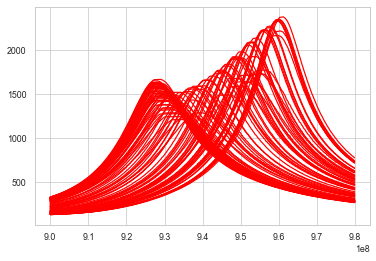

In [81]:

reference_file = r"C:\Users\abensolt\Desktop\raw_data\MWrepro_1084.txt"# reference for probe 1084
myfiles1=[]
mean_res_freq = []
mean_res_amp = []
mean_FWHM = []
mean_res_phase = []
max_res_freq = []
max_res_amp = []
max_res_phase = []
max_FWHM = []
WLR_OC = []
WLR_WC = []
left_res_freq = []
left_res_amp = []
left_FWHM = []
left_res_phase = []
WLR = []
GVF = []
num = 0
df = pd.read_csv(reference_file, sep='\t')
phase_bool=False
amplitude_bool=True
probe = "Probe1084"
number_of_samples = 0
starting_time  =[int( elem [:2]+ elem[3:5]) for elem in df['Time Start (hh:mm)']] 
number_of_measures = len(starting_time)# total number of mesures 
ending_time =[int( elem [:2]+ elem[3:5]) for elem in  df['Time End (hh:mm)']] 
ending_time = [ending_time[i]-40 if ending_time[i]-starting_time[i]>40 else ending_time[i] for i in range(len(ending_time))  ]
Date = [''.join((elem[:10].split('/') )[::-1] )for elem in df['Date (dd/mm/yyyy)']]
files = [list(range(starting_time[i],ending_time[i]+1) )for i in range(number_of_measures )] 
for i in range(number_of_measures):
        dfs=[]
        for f in files[i]:
            if f % 100 >= 60 :
                f = f + 40  
            if len(str(f))<4:
                f=str(f).rjust(4, '0')
            path = r"C:\Users\abensolt\Desktop\raw_data\\"+probe+"/"+Date[i]+"/MW {} {}.txt".format(Date[i],f)
            myfiles1.append(path)
            #print("collecting data from the file MW {} {}.txt".format(folder,f))
            df1 = pd.read_csv(path, delimiter = "\t")
            if(int(df1.iloc[0,2*500+1])>58490):
                num+=1
            dfs.append(df1)

        concated_df = pd.concat(dfs)# concatenate dfs with a specific value of WLR 
        if(df.iloc[i][5]=="99.9" or df.iloc[i][5]==' '): # remove samples with GVF bigger then 99.9%
            continue
        #extract mean values of function's parameters 
        mean_fitting_parameters = mean_fitting_amplitudes(concated_df,df.iloc[i][6],df.iloc[i][5],False)#True to print graphs
        mean_FWHM.append(mean_fitting_parameters[3])
        mean_res_freq.append(mean_fitting_parameters[2])
        mean_res_amp.append(mean_fitting_parameters[1])
        #extract best values of function's parameters 
        max_fitting_parameters = max_fitting_amplitudes(concated_df,df.iloc[i][6],df.iloc[i][5],False)#True to print graphs
        max_FWHM.append(max_fitting_parameters[3])
        max_res_freq.append(max_fitting_parameters[2])
        max_res_amp.append(max_fitting_parameters[1])
        #extract good values of function's parameters
        left_fitting_parameters = left_fitting_amplitudes(concated_df,df.iloc[i][6],df.iloc[i][5],False)
        left_FWHM.append(left_fitting_parameters[3])
        left_res_freq.append(left_fitting_parameters[2])
        left_res_amp.append(left_fitting_parameters[1])
#         res_phase.append(extract_phase(concated_df,mean_fitting_parameters[2],True))##not usefull
        #print("res freq from phase :",res_freq_from_phase)
        #concated_df.to_excel("output.xlsx") 
        
        WLR.append(df.iloc[i][6])
        GVF.append(df.iloc[i][5])
        WLR_OC.append(float((df['WLR OC %'][i])[:-4]))
        WLR_WC.append(float((df['WLR WC %'][i])[:-4]))
        number_of_samples+=1
print("total number of samples",number_of_measures)
print("number of samples",number_of_samples)


## Using seaborn to plot the data

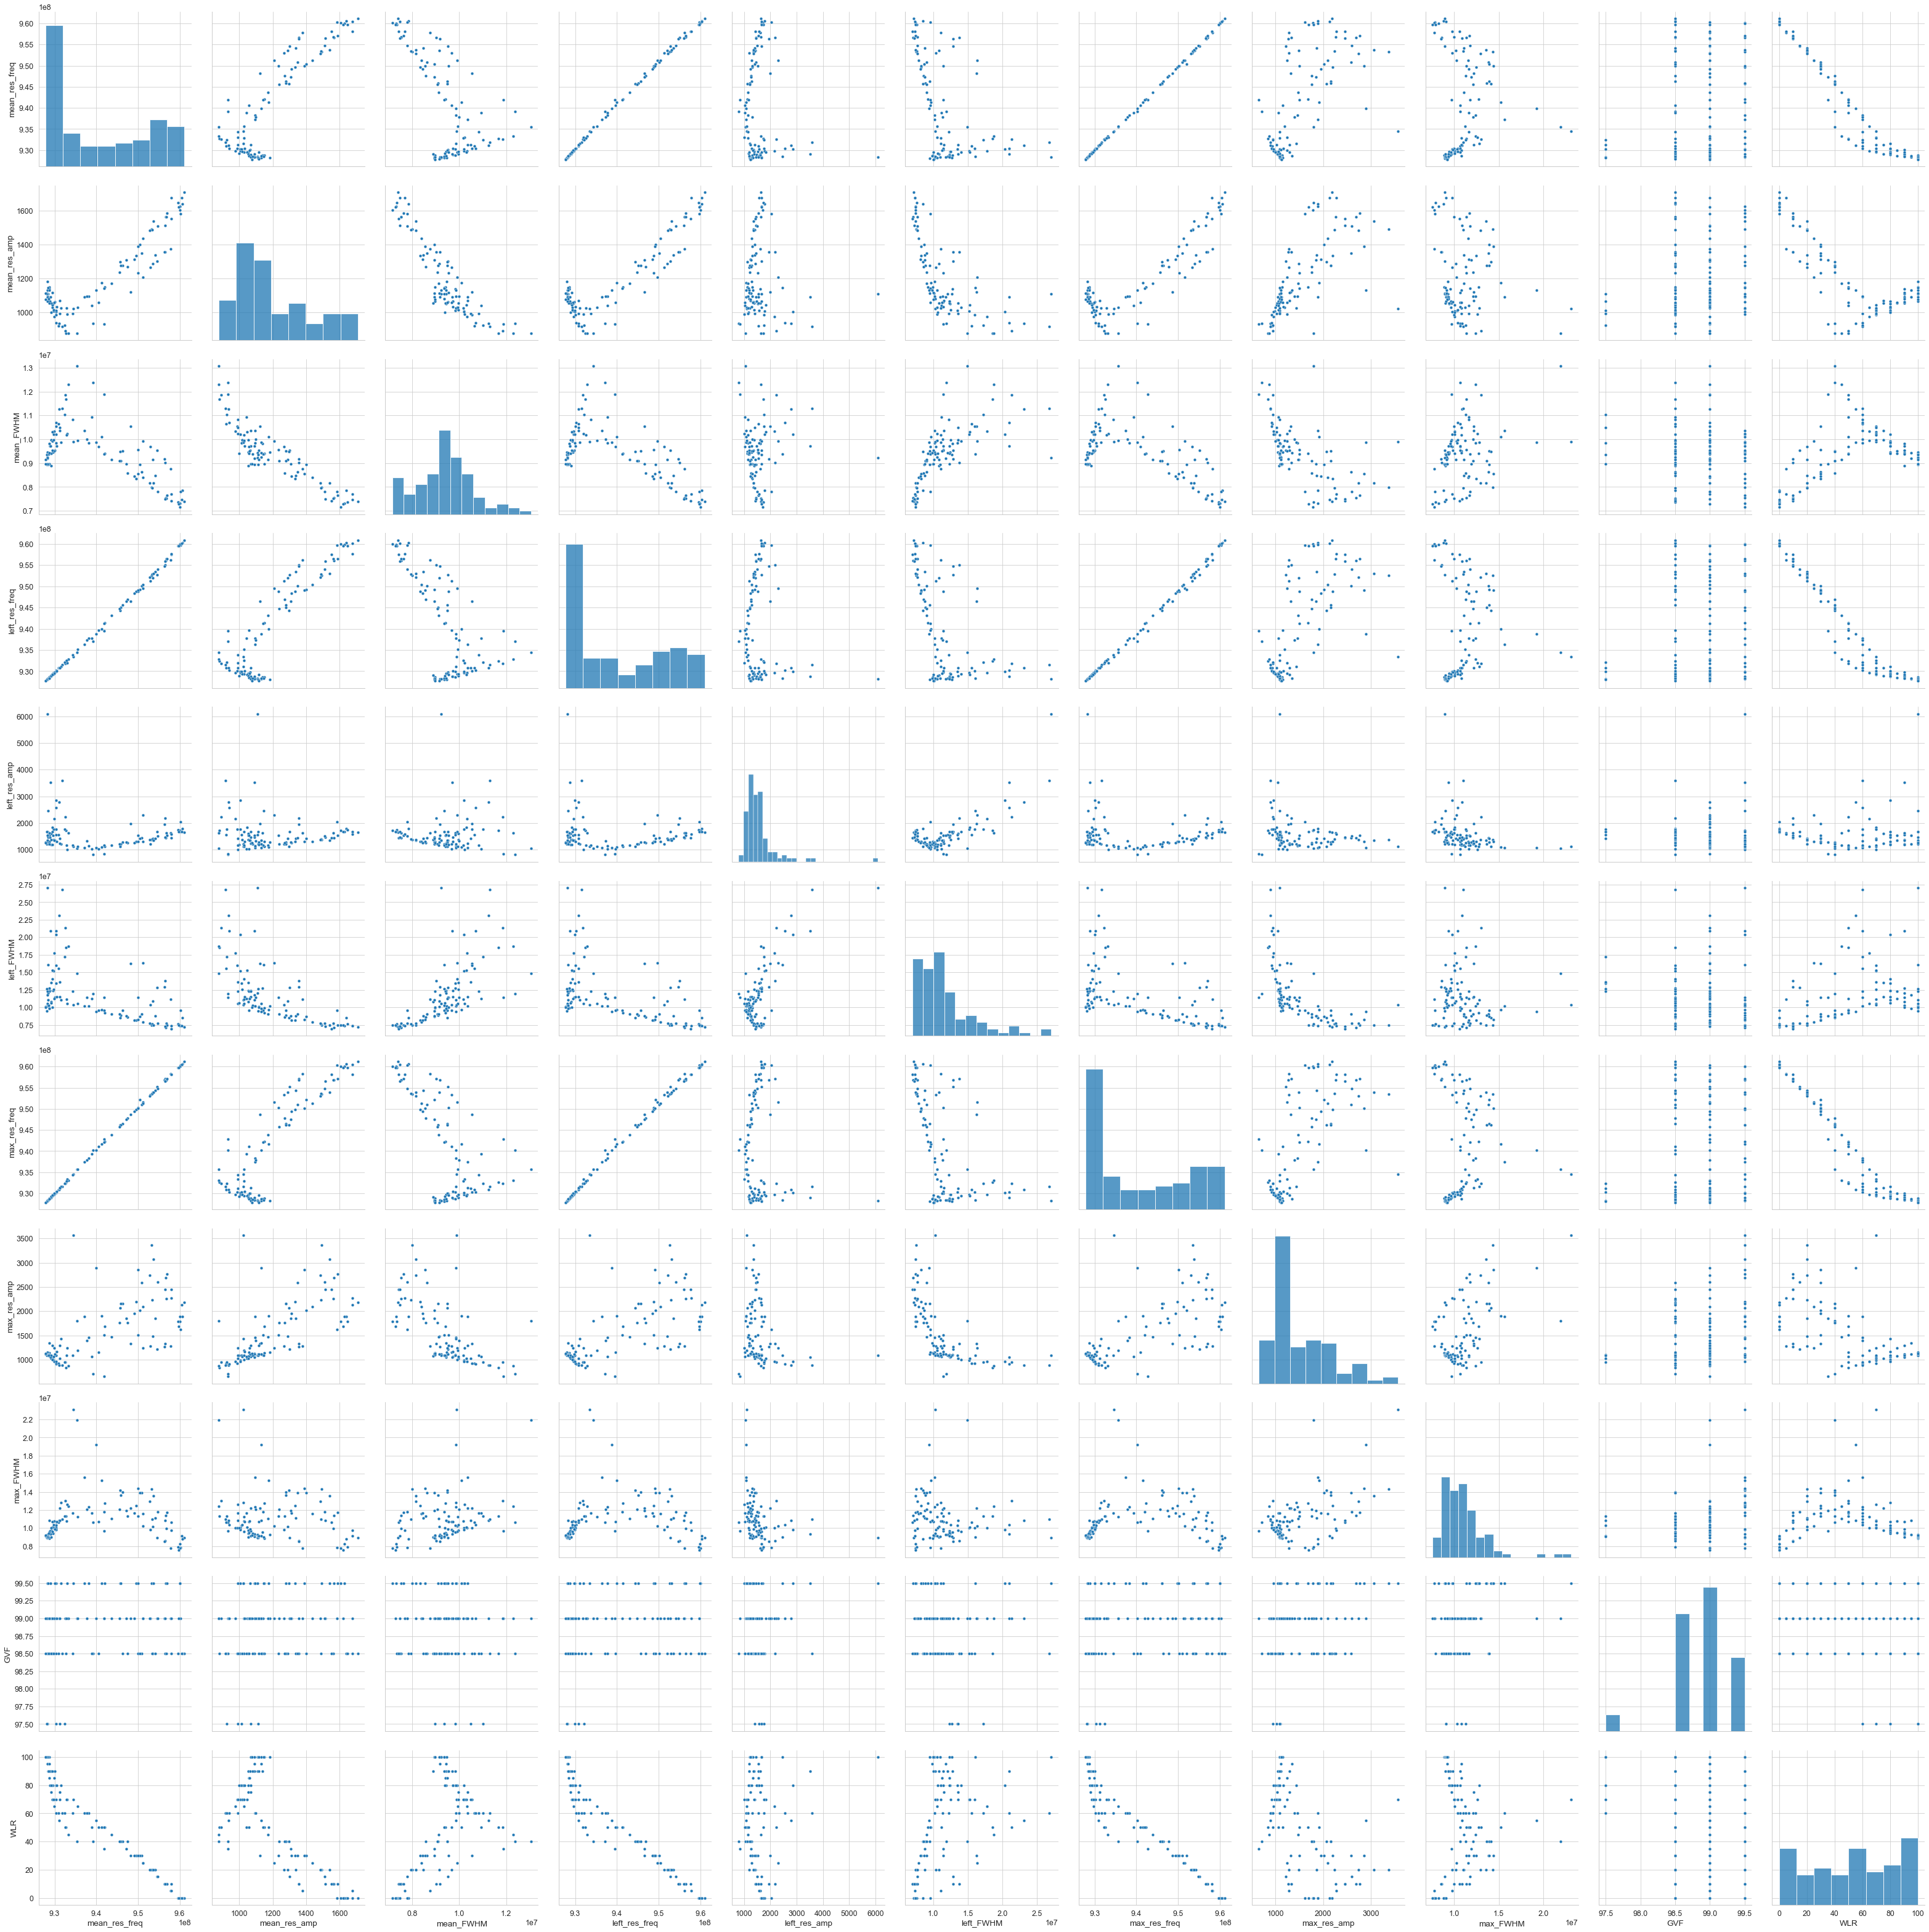

In [92]:

import seaborn as sns 

data_df = pd.DataFrame({"mean_res_freq" : mean_res_freq,
                        "mean_res_amp" : mean_res_amp,
                        "mean_FWHM" :mean_FWHM,
                        "left_res_freq" : left_res_freq,
                        "left_res_amp" : left_res_amp,
                        "left_FWHM" :left_FWHM,
                        "max_res_freq" : max_res_freq,
                        "max_res_amp" : max_res_amp,
                        "max_FWHM" :max_FWHM,
                        "GVF" :GVF,
                         "WLR"  :WLR}
                        ).astype(float)
#data_df.to_csv('data.csv')
sns.set_style('whitegrid')
g=sns.pairplot(data_df)
g.fig.set_size_inches(45,45)
 
plt.show()


### Remarque
Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. 
So, when two features have high correlation, we can drop one of the two features.

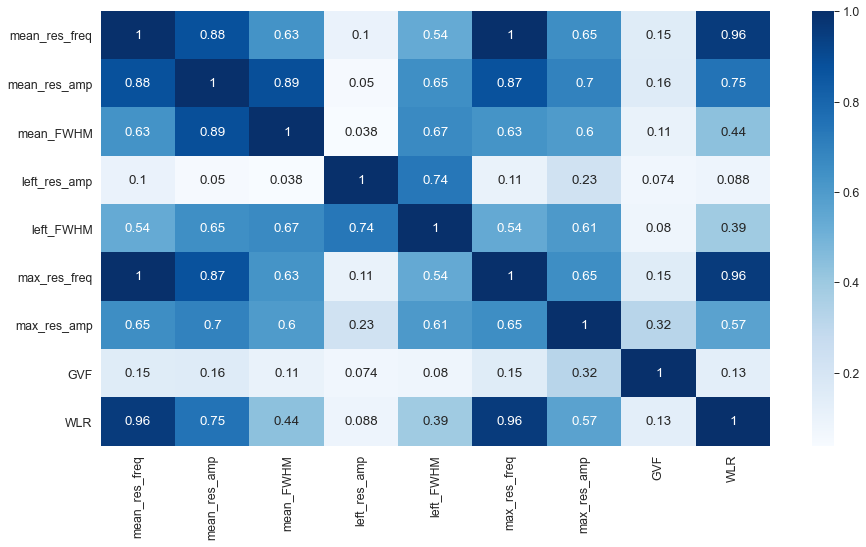

Index(['mean_res_freq', 'mean_res_amp', 'mean_FWHM', 'left_res_amp',
       'left_FWHM', 'max_res_freq', 'max_res_amp', 'GVF', 'WLR'],
      dtype='object')


In [113]:
plt.figure(figsize=(15,8))
sns.set_context('paper',font_scale=1.4)
feature_matrix = abs(data_df.corr())
sns.heatmap(feature_matrix,annot= True,cmap='Blues')
plt.show()
sns.set_context('paper',font_scale=1.4)
#drop max_FWHM beceause its correlation with WLR is very low
if "left_res_freq" in data_df.columns:   
    data_df.drop("left_res_freq",inplace=True,axis=1)
if "max_FWHM" in data_df.columns:   
    data_df.drop("max_FWHM",inplace=True,axis=1)
print(data_df.columns )

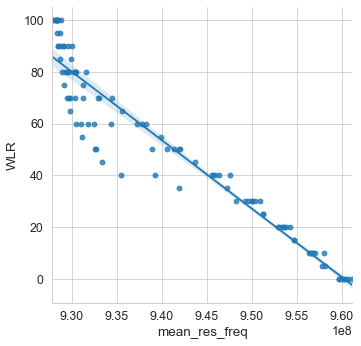

In [27]:
#using seaborns linear fitting 
sns.set_context('paper',font_scale=1.4)
sns.lmplot(x="mean_res_freq",y='WLR',data=data_df)
plt.show()

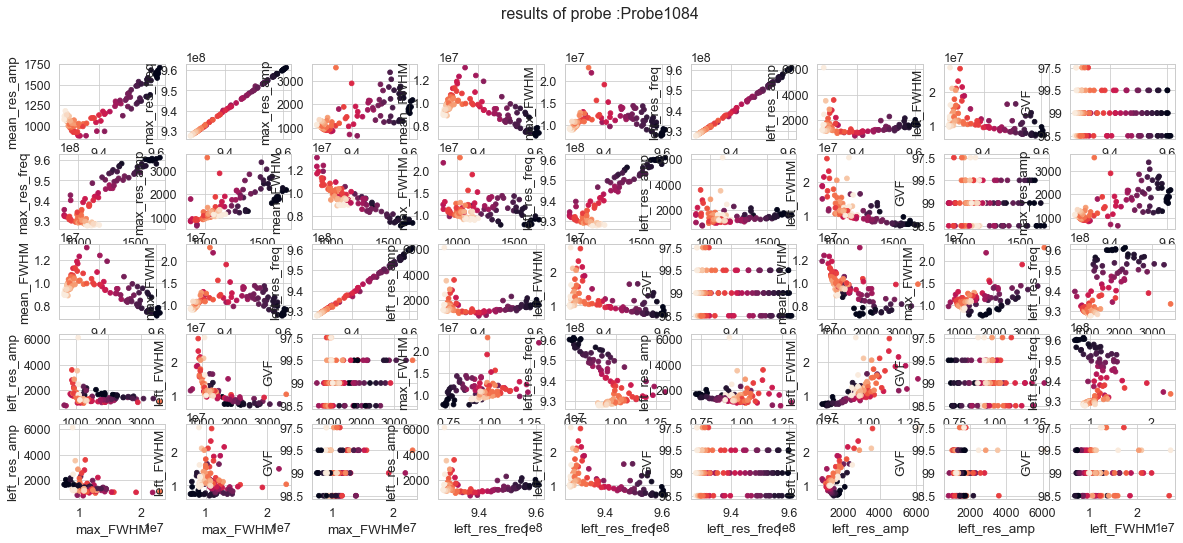

In [114]:
#plots of the parameters 2 by 2 colored by the WLR: to find the best barameters for the calssification task 
parameters = [mean_res_freq,mean_res_amp,max_res_freq,max_res_amp,mean_FWHM,max_FWHM,left_res_freq,
       left_res_amp, left_FWHM,GVF]
lebels = ["mean_res_freq","mean_res_amp","max_res_freq","max_res_amp","mean_FWHM","max_FWHM",'left_res_freq',
       'left_res_amp', 'left_FWHM',"GVF"]
param_num = len(parameters)
fig, axs = plt.subplots(5, int(sum(range(param_num))/5),figsize=(20,8))
fig.suptitle("results of probe :"+probe, fontsize=16)
index=0
index1=0
sns.set_context('paper')
for i in range(param_num-1):
    for j in range(i+1,param_num):
        axs[index, index1].scatter(parameters[i],parameters[j],c=WLR)
        axs[index, index1].set_xlabel(lebels[i])
        axs[index, index1].set_ylabel(lebels[j])
        index1+=1
        if(index1==int(sum(range(param_num))/5)):
            index=index+1
            index1=0
# fig.tight_layout(pad=0.5)


# Applying machine learning algorithm on the data

## Data normalization

In [123]:
#Data Normalization using Feature scaling
from sklearn import preprocessing
parameters = [mean_res_freq,mean_res_amp,max_res_freq,max_res_amp,mean_FWHM,max_FWHM,left_res_freq,
       left_res_amp, left_FWHM,GVF,WLR]
lebels = ["mean_res_freq","mean_res_amp","max_res_freq","max_res_amp","mean_FWHM","max_FWHM",'left_res_freq',
       'left_res_amp', 'left_FWHM',"GVF","WLR" ]

normalized_param = []


for param in parameters:
    param = np.array(param)
    param= param.astype(np.float)
    normalized = (param - min(param)) / (max(param) - min(param) )
    normalized_param.append(normalized.reshape(1,len(param)))

normalized_data_df = pd.DataFrame({"mean_res_freq":normalized_param[0][0],
                                   "mean_res_amp":normalized_param[1][0],
                                   "max_res_freq":normalized_param[2][0],
                                   "max_res_amp":normalized_param[3][0],
                                   "mean_FWHM":normalized_param[4][0],
                                   'left_res_amp':normalized_param[7][0],
                                   'left_FWHM':normalized_param[8][0],
                                   "GVF":normalized_param[9][0],
                                   "WLR":normalized_param[10][0] } ).astype(float)
x_allfeature = np.stack([normalized_param[0][0],normalized_param[1][0],normalized_param[2][0],normalized_param[4][0]
             ,normalized_param[7][0],normalized_param[8][0],normalized_param[9][0]],axis=1) 
y  = normalized_param[10][0]
#taking only mean_res_freq
x = normalized_param[0][0]
#selecting the input parameter and the WLR as a label
x_name = lebels[0]
y_name = lebels[4]


## Linear regression

Mean absolute error:  0.06300108562610232


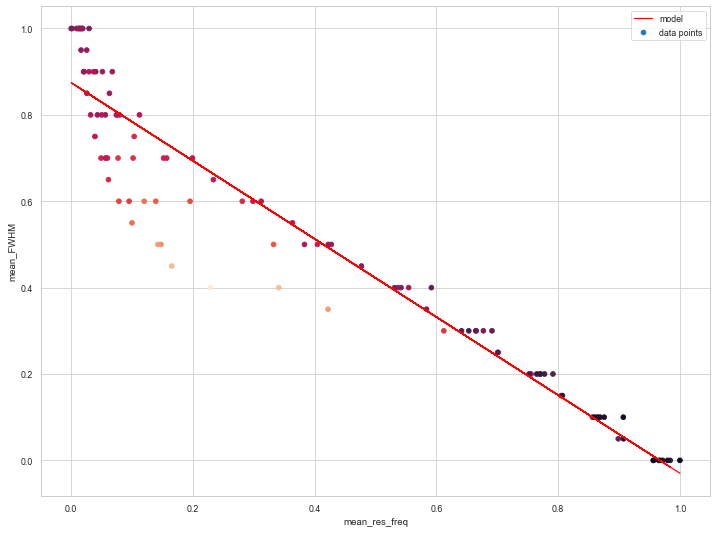

In [124]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
x_train, x_test ,y_train , y_test = train_test_split(x,y,test_size=0.2,random_state=2)
x_train = x_train.reshape(-1, 1)  
y_train = y_train.reshape(-1, 1)  
x_test = x_test.reshape(-1, 1)  
y_test = y_test.reshape(-1, 1)
Linreg = LinearRegression()
Linreg.fit(x_train,y_train)

y_pred = Linreg.predict(x_test)
print("Mean absolute error: ",mean_absolute_error(y_pred,y_test))
file = open(file_name,"a")
file.write("Results of Linear regression algorithm on data from probe {}:\n".format(probe) )
file.write("Mean absolute error: {}\n".format(mean_absolute_error(y_pred,y_test)))
file.write("------------------------------------------------\n" )
file.close()
if len(x==1):
    plt.figure(figsize=(12,9))
    plt.scatter(x,y, label='data points',c=label)
    data1 = x.reshape(-1, 1)  
    pred=Linreg.predict(data1)
    plt.plot(data1,pred,c='r', label='model')
    plt.ylabel(y_name)
    plt.xlabel(x_name)
    plt.legend()
    plt.savefig('figures\\Linear_regression_pb{}.png'.format(probe))


## Decision tree

mean_absolute_error : 0.08552791843233018


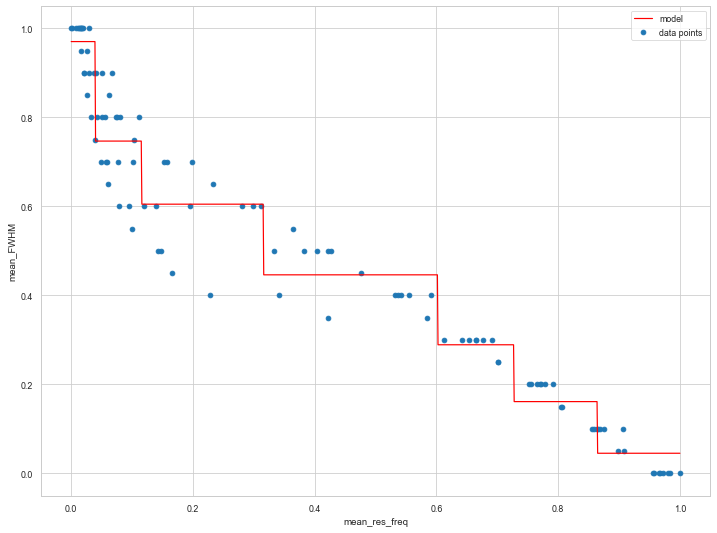

In [125]:
# =============================================================================

x_train, x_test ,y_train , y_test = train_test_split(x,y,test_size=0.2,random_state=2)
x_train = x_train.reshape(-1, 1)  
y_train = y_train.reshape(-1, 1)  
x_test = x_test.reshape(-1, 1)  
y_test = y_test.reshape(-1, 1)
dt = DecisionTreeRegressor(max_depth=3,min_samples_leaf=0.1)
dt.fit(x_train,y_train)
y_pred=dt.predict(x_test)
print("mean_absolute_error :",mean_absolute_error(y_pred,y_test))
# file = open(file_name,"a")
# file.write("Results of Decision tree algorithm on data from probe {}:\n".format(probe) )
# file.write("Mean absolute error: {}\n".format(mean_absolute_error(y_pred,y_test)))
# file.write("------------------------------------------------\n" )
# file.close()
plt.figure(figsize=(12,9))
plt.scatter(x,y, label='data points')
x_model = np.linspace(min(x), max(y), 1000)
pred=dt.predict(x_model.reshape(-1,1))
plt.plot(x_model,pred,c='r', label='model')

plt.ylabel(y_name)
plt.xlabel(x_name)
plt.legend()
plt.savefig('figures\\Decision_tree_pb{}.png'.format(probe))

## Kernel Ridge Regression

mean_absolute_error : 0.05431125051975035


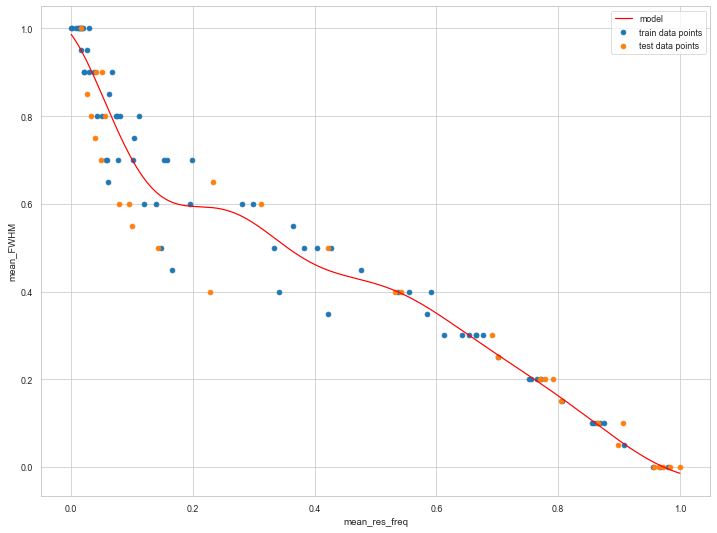

In [126]:
from sklearn.kernel_ridge import KernelRidge
import numpy as np

x_train, x_test ,y_train , y_test = train_test_split(x,y,test_size=0.3,random_state=2)
x_train = x_train.reshape(-1, 1)  
y_train = y_train.reshape(-1, 1)  
x_test = x_test.reshape(-1, 1)  
y_test = y_test.reshape(-1, 1)
krr_loss = []
# degrees = list(range(50))
# gammas = list(range(1000))
# for gama in gammas:
krr = KernelRidge(alpha=0.1,kernel ='rbf',gamma=31 )
krr.fit(x_train,y_train)
y_pred=krr.predict(x_test)
print("mean_absolute_error :",mean_absolute_error(y_pred,y_test))
file = open(file_name,"a")
file.write("Results of Kernel Ridge Regression (kernek = rbf, gamma = 31) algorithm on data from probe {}\n".format(probe) )
file.write("Mean absolute error: {}\n".format(mean_absolute_error(y_pred,y_test)))
file.write("------------------------------------------------\n" )
file.close
krr_loss.append(mean_absolute_error(y_pred,y_test))
plt.figure(figsize=(12,9))
plt.scatter(x_train,y_train, label='train data points')
plt.scatter(x_test,y_test, label='test data points')
x_model = np.linspace(min(x), max(x), 1000)
x_model=x_model.reshape(-1,1)
pred=krr.predict(x_model)
plt.plot(x_model,pred,c='r', label='model')
plt.ylabel(y_name)
plt.xlabel(x_name)
plt.legend()
plt.savefig('figures\\KRR_pb{}.png'.format(probe))
# degree with lowest test loss is 41
# gamma with lowest test loss is 31
 

In [143]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import numpy as np
x_train, x_test ,y_train , y_test = train_test_split(x,y,test_size=0.3,random_state=2)
x_train = x_train.reshape(-1, 1)  

x_test = x_test.reshape(-1, 1)  

estimator = SVR()
parameters={
                "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],                         
                "gamma": list(range(40)),
                "degree": list(range(40))
               
                
            }
cv        = 5

model = GridSearchCV(estimator, parameters,cv=cv)

model.fit(x_train, y_train)
y_pred=model.predict(x_test)
print("mean_absolute_error :",mean_absolute_error(y_pred,y_test ))

plt.figure()
sns.set_context('paper',font_scale=1.4)
plt.scatter(x,y, label='data points')
x_model = np.linspace(min(x), max(y), 1000)
x_model=x_model.reshape(-1,1)
pred=model.predict(x_model)
plt.plot(x_model,pred,c='r', label='model')
plt.ylabel(y_name)
plt.xlabel(x_name)
plt.show()

KeyboardInterrupt: 

## Neural network


In [ ]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
from math import sqrt
import matplotlib.pyplot as plt

import numpy as np

 
torch.manual_seed(1)    # reproducible
# norm_res_freq_OC= (res_freq_OC - min(res_freq_OC)) / (max(res_freq_OC) - min(res_freq_OC) )
# norm_WLR_OC= (WLR_OC - min(WLR_OC)) / (max(WLR_OC) - min(WLR_OC) )
x_NN = (torch.tensor(x).float())
y_NN = (torch.tensor(y).float())           

# torch can only train on Variable, so convert them to Variable
x_NN, y_NN = Variable(x_NN), Variable(y_NN)
x_train, x_test ,y_train , y_test = train_test_split(x_NN,y_NN,test_size=0.2,random_state=2)
x_train = x_train.reshape(-1, 1)  
y_train = y_train.reshape(-1, 1)  
x_test = x_test.reshape(-1, 1)  
y_test = y_test.reshape(-1, 1)
# this is one way to define a network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

train_loss=[]
net = Net(n_feature=1, n_hidden=100, n_output=1)     # define the network
# print(net)  # net architecture
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
# train the network
for t in range(1000):
    prediction = net(x_train)     # input x and predict based on x
    loss = loss_func(prediction, y_train)  
    train_loss.append(loss.detach().cpu().numpy())# must be (1. nn output, 2. target)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    # plot and show learning process
with torch.no_grad():
    #plt.show()
    y_pred = net(x_test)
    x_model = torch.unsqueeze(torch.linspace(0,1, 1000), dim=1) 
    y_vec = net(x_model)
    plt.plot(x_model, y_vec , c='r',label='Network output')
    plt.scatter(x_train, y_train, label='data points')
    plt.scatter(x_test, y_test, label='test points')
    plt.grid()
    plt.legend()
    plt.savefig('figures\\Pythorch_NN_pb{}.png'.format(probe))
    y_pred = net(x_test)
#     plt.figure(figsize=(12,7))
#     plt.plot(list(range(len(train_loss))), train_loss, label='data points')
#     plt.show()
    print("Mean absolute error: {}\n".format(mean_absolute_error(y_pred,y_test)))
    file = open(file_name,"a")
    file.write("Results of pytorch NN algorithm on data from probe {}\n".format(probe) )
    file.write("Mean absolute error: {}\n".format(mean_absolute_error(y_pred,y_test)))
    file.write("------------------------------------------------\n" )
    file.close()
#     print(len(train_loss))

In [ ]:
##Tensorflow NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing as tfpreprocessing
# Make numpy printouts easier to read.
def plot_res_freq(x, y):
    plt.figure(figsize=(12,8))
    plt.scatter(train_features['res_freq'], train_labels, label='Data')
    plt.scatter(test_features['res_freq'], test_labels, label='Data')
    plt.plot(x, y, color='r', label='Predictions')
    plt.xlabel('res_freq')
    plt.ylabel('WLR')
    plt.title("Fitting the data using 1 regressor")
    plt.legend()
    plt.savefig('figures\\Tf_NN_pb{}.png'.format(probe))
    plt.show()
def build_and_compile_model(norm):
    model = keras.Sequential([
          norm,
          layers.Dense(20, activation='relu'),
          layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model
def plot_loss(history):
      plt.figure()
      plt.plot(history.history['loss'], label='loss')
      plt.plot(history.history['val_loss'], label='val_loss')
      plt.xlabel('Epoch')
      plt.ylabel('Error [MPG]')
      plt.legend()
      plt.grid(True)
        
      plt.show()
def Tf_regresor(data_df):
    train_dataset = data_df.sample(frac=0.8, random_state=0)
    test_dataset = data_df.drop(train_dataset.index)
    train_features = train_dataset.copy()
    test_features = test_dataset.copy()

    train_labels = train_features.pop('WLR')
    test_labels = test_features.pop('WLR')
    np.set_printoptions(precision=3, suppress=True)
    normalizer = tfpreprocessing.Normalization(axis=-1)
    normalizer.adapt(np.array(train_features))

    res_freq_normalizer = tfpreprocessing.Normalization(input_shape=[1,], axis=None)
    res_freq_normalizer.adapt(np.array(train_features['res_freq']))
    # res_freq_model = tf.keras.Sequential([
    #     res_freq_normalizer,
    #     layers.Dense(units=1)
    # ])

    # res_freq_model.compile(
    #     optimizer=tf.optimizers.Adam(learning_rate=0.1),
    #     loss='mean_absolute_error')
    res_freq_model = build_and_compile_model(res_freq_normalizer)
    history = res_freq_model.fit(
        train_features['res_freq'], train_labels,
        epochs=500,
        # suppress logging
        verbose=0,
        # Calculate validation results on 20% of the training data
        validation_split = 0.2)
    plot_loss(history)
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()
    test_results = {}

    test_results['res_freq_model'] = res_freq_model.evaluate(
        test_features['res_freq'],
        test_labels, verbose=0)
    return res_freq_model,test_results

train_dataset = normalized_data_df.sample(frac=0.8, random_state=0)
test_dataset = normalized_data_df.drop(train_dataset.index)
train_features = train_dataset.copy()
test_features = test_dataset.copy()
res_freq_model,test_results = Tf_regresor(normalized_data_df)
train_labels = train_features.pop('WLR')
test_labels = test_features.pop('WLR')
x_generated = tf.linspace(min(train_features['res_freq']), max(train_features['res_freq']),1000)
y_generated = res_freq_model.predict(x_generated)
y_pred = res_freq_model.predict(test_features['res_freq'])

plot_res_freq(x_generated,y_generated)
print("Mean absolute error: {}\n".format(mean_absolute_error(y_pred,test_labels)))
y_generated
file = open(file_name,"a")
file.write("Results of Tensorflow NN algorithm on data from probe {}\n".format(probe) )
file.write("Mean absolute error: {}\n".format(mean_absolute_error(y_pred,test_labels)))
file.write("------------------------------------------------\n" )
file.close()



# Clustering
## K-means clustering

1 corresponds to samples in the OC


0 corresponds to samples in the WC

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
x = normalized_param[0][0]
y = normalized_param[4
                    ][0]

data_stacked=np.stack((x,y), axis=1)
kmeans = KMeans(2,init='random').fit(data_stacked)

plt.figure(figsize=(12,7))
plt.scatter(x,y, c=kmeans.labels_,cmap='viridis')
plt.ylabel("WLR")
plt.xlabel("res_freq")
plt.title("Data clustering using kmeans")
plt.show()
cluster1_res_fre = [res_freq[i]for i in range(len(res_freq)) if kmeans.labels_[i]==0 ]
cluster1_WLR = [WLR[i] for i in range(len(res_freq)) if kmeans.labels_[i]==0 ]
cluster2_res_fre = [res_freq[i]for i in range(len(res_freq)) if kmeans.labels_[i]==1 ]
cluster2_WLR = [WLR[i] for i in range(len(res_freq)) if kmeans.labels_[i]==1 ]


### OC/WC Label extracting
We estimated the classes that each point belong to. First by labeling the points with WLR under 30% as OC and the points with WLR over 70% as WC. Then for the remaining points by caluculating from the reference file the difference between the WLR estimated using each model(WC model and OC model) and the true WLR value and we chose as label the one with smallest difference.

In [ ]:
print(normalized_data_df[["res_freq","res_amp","FWHM","GVF"]])
print(normalized_data_df[["res_freq","res_amp","FWHM","GVF"]].iloc[3])

In [ ]:

clusterWC = []
clusterWC_WLR = []
clusterOC= []
clusterOC_WLR = []
labels = []

for i in range(len(WLR)):
    if WLR[i]<30 :
        clusterOC.append(list(normalized_data_df[["res_freq","res_amp","FWHM","GVF"]].iloc[i]))
        clusterOC_WLR.append(normalized_data_df["WLR"][i])
        labels.append(1)
    elif WLR[i]>=70 or normalized_data_df["res_freq"][i]<0.2 :
        clusterWC.append(list(normalized_data_df[["res_freq","res_amp","FWHM","GVF"]].iloc[i]))
        clusterWC_WLR.append(normalized_data_df["WLR"][i])
        labels.append(0)
    elif abs(WLR_OC[i]-WLR[i]) < abs(WLR_WC[i]-WLR[i]):
        clusterOC.append(list(normalized_data_df[["res_freq","res_amp","FWHM","GVF"]].iloc[i]))
        clusterOC_WLR.append(normalized_data_df["WLR"][i])
        labels.append(1)
    else:
        clusterWC.append(list(normalized_data_df[["res_freq","res_amp","FWHM","GVF"]].iloc[i]))
        clusterWC_WLR.append(normalized_data_df["WLR"][i])
        labels.append(0)
clusterWC_df = pd.DataFrame(data=clusterWC,columns =["res_freq","res_amp","FWHM","GVF"])
clusterOC_df = pd.DataFrame(data=clusterOC,columns =["res_freq","res_amp","FWHM","GVF"])
#samples = np.stack((np.array(res_freq),np.array(WLR)), axis=1)


In [ ]:

from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=3)
transformed  = pca.fit_transform(X=normalized_data_df.drop(["GVF"],axis=1))
x_component, y_component = transformed[:, 0], transformed[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=labels, cmap='viridis', s=50, alpha=8/10)
plt.title('input data after PCA transformation')
plt.show()



In [ ]:
#training a classifier with the labels
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
x_class = np.array(normalized_data_df)
print(x_class.shape)
y_class = np.array(labels).reshape(-1,1)
x_train, x_test ,y_train , y_test = train_test_split(x_class,y_class,test_size=0.2,random_state=2)
 
counter = 0
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
#print(clf.predict_proba(x_train))
clf.score(x_train, y_train)

pred_labels = clf.predict(x_class)
miss_classified_rf = []
miss_classified_wlr = []

for i in range(len(pred_labels)):
    if pred_labels[i] != labels[i] :
        miss_classified_rf.append(normalized_data_df["res_freq"][i])
        miss_classified_wlr.append( normalized_data_df["WLR"][i])
plt.figure(figsize=(12,9))
plt.title("supervised Classifier: linear regression")
# plt.scatter([elem[0] for elem in x_train],[elem[1] for elem in x_train] )
# plt.scatter([elem[0] for elem in x_test],[elem[1] for elem in x_test] )
plt.scatter(normalized_data_df["res_freq"],normalized_data_df["WLR"],c=pred_labels,cmap=plt.cm.coolwarm)
plt.scatter(miss_classified_rf,miss_classified_wlr,marker='x',c='g',s=100,label = 'misclassified points')
plt.legend()
plt.show()
plt.figure(figsize=(12,9))


In [ ]:
#comparing clustering and supervised classification  

kmeans_counter = 0
lr_counter = 0
pred_labels = clf.predict(x_class)
for i in range(len(labels)):
    if kmeans.labels_[i] == labels[i]:kmeans_counter+=1
    if pred_labels[i] != labels[i]:lr_counter+=1
print(lr_counter)
print("logistic regression score :",1-(lr_counter/len(labels)))
print("k-means score :",1-(kmeans_counter/len(labels)))


In [ ]:
miss_classified_rf = []
miss_classified_wlr = []
plt.figure(figsize=(12,9))
for i in range(len(labels)):
    if kmeans.labels_[i] == labels[i] :
        miss_classified_rf.append(normalized_data_df["res_freq"][i])
        miss_classified_wlr.append( normalized_data_df["WLR"][i])
plt.title("unsupervised Classifier: K-means clustering")
# plt.scatter([elem[0] for elem in x_train],[elem[1] for elem in x_train] )
# plt.scatter([elem[0] for elem in x_test],[elem[1] for elem in x_test] )
plt.scatter(normalized_data_df["res_freq"],normalized_data_df["WLR"],c=pred_labels,cmap=plt.cm.coolwarm)
plt.scatter(miss_classified_rf,miss_classified_wlr,marker='x',c='g',s=100,label = 'misclassified points')
plt.legend()
plt.show()

In [ ]:
from sklearn import svm
svm_samles =  np.stack((x,y), axis=1)
svm_labels =  labels
x_train, x_test ,y_train , y_test = train_test_split(svm_samles,svm_labels ,test_size=0.2,random_state=2)
 
clf = svm.SVC()

h = .01# step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(x_train, y_train)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(x_train, y_train)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(x_train, y_train)
lin_svc = svm.LinearSVC(C=C).fit(x_train, y_train)
x_min, x_max =svm_samles[:, 0].min() - 0.1, svm_samles[:, 0].max() + 0.1
y_min, y_max =svm_samles[:, 1].min() - 0.1, svm_samles[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']
plt.figure(figsize=(14,9))
for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    # Plot also the training points
    plt.scatter(svm_samles[:, 0],svm_samles[:, 1], c=svm_labels, cmap=plt.cm.coolwarm)
    plt.xlabel('res freq')
    plt.ylabel('wlr')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
 

In [ ]:
#Fitting the Oil Continuous Part
clusterOC_res_freq = np.array(clusterOC_res_freq) 
clusterOC_WLR = np.array(clusterOC_WLR) 
x_train, x_test ,y_train , y_test = train_test_split(clusterOC_res_freq,clusterOC_WLR,test_size=0.2,random_state=2)
x_train = x_train.reshape(-1, 1)  
y_train = y_train.reshape(-1, 1)  
x_test = x_test.reshape(-1, 1)  
y_test = y_test.reshape(-1, 1)
for deg in range(10):
    krr = KernelRidge(alpha=0.1,kernel ='poly',degree=deg)
    krr.fit(x_train,y_train)
    print(deg)
    y_pred=krr.predict(x_test)
    print("mean_absolute_error :",mean_absolute_error(y_pred,y_test))

plt.figure(figsize=(12,9))
plt.scatter(x_train,y_train, label='data points')
x_model = np.linspace(min(x), max(x), 1000)
x_model=x_model.reshape(-1,1)
pred=krr.predict(x_model)
plt.scatter(x_model,pred,c='r', label='model')
plt.ylabel(y_name)
plt.xlabel(x_name)
plt.legend()
plt.show()


In [ ]:
## #Fitting the water Continuous Part
clusterWC_res_freq = np.array(clusterWC_res_freq) 
clusterWC_WLR = np.array(clusterWC_WLR) 
WC_x_train, WC_x_test ,WC_y_train , WC_y_test = train_test_split(clusterWC_res_freq,clusterWC_WLR,test_size=0.2,random_state=2)
WC_x_train = WC_x_train.reshape(-1, 1)  
WC_y_train = WC_y_train.reshape(-1, 1)  
WC_x_test = WC_x_test.reshape(-1, 1)  
WC_y_test = WC_y_test.reshape(-1, 1)
data_df_WC = pd.DataFrame({"res_freq" : clusterWC_res_freq,
                         "WLR"  :clusterWC_WLR}
                        ).astype(float)
data_df_OC = pd.DataFrame({"res_freq" : clusterOC_res_freq,
                         "WLR"  :clusterOC_WLR}
                        ).astype(float) 
 
krr = KernelRidge(alpha=0.1,kernel ='rbf',gamma=34)
krr.fit(WC_x_train,WC_y_train)
x1 = tf.linspace(min(data_df_WC['res_freq']), max(data_df_WC['res_freq']),1000)
x1=np.array(x1).reshape(-1, 1)  
krr_pred=krr.predict(x1)
WC_y_pred=krr.predict(WC_x_test)
print("mean_absolute_error WC :",mean_absolute_error(WC_y_pred,WC_y_test))
#fitting oil contineous part 
OC_x_train, OC_x_test ,OC_y_train , OC_y_test = train_test_split(clusterOC_res_freq,clusterOC_WLR,test_size=0.2,random_state=2)
OC_x_train = OC_x_train.reshape(-1, 1)  
OC_y_train = OC_y_train.reshape(-1, 1)  
OC_x_test = OC_x_test.reshape(-1, 1)  
OC_y_test = OC_y_test.reshape(-1, 1)
Linreg = LinearRegression()
Linreg.fit(OC_x_train,OC_y_train)
x2 = tf.linspace(min(data_df_OC['res_freq']), max(data_df_OC['res_freq']),1000)
x2=np.array(x2).reshape(-1, 1)  
Linreg_pred=Linreg.predict(x2)
OC_y_pred=Linreg.predict(OC_x_test)
print("mean_absolute_error OC :",mean_absolute_error(OC_y_pred,OC_y_test))
#plotting results 
plt.figure(figsize=(12,8))
plt.scatter(WC_x_train,WC_y_train,marker='o', label='WC train points')
plt.scatter(WC_x_test,WC_y_test,marker='x', label='WC test points')
plt.plot(x1, krr_pred, label='Kernel Ridge Regression')
plt.scatter(OC_x_train,OC_y_train,marker='o', label='OC train points')
plt.scatter(OC_x_test,OC_y_test,marker='x', label='OC test points')
plt.plot(x2, Linreg_pred, label='Linear regression')
plt.xlabel('res_freq')
plt.ylabel('WLR')
plt.title("Fitting the data using 2 regressors")
plt.legend()
plt.show()
print("global mean_absolute_error  :",(mean_absolute_error(OC_y_pred,OC_y_test)+mean_absolute_error(WC_y_pred,WC_y_test))/2)


In [ ]:
from sklearn.kernel_ridge import KernelRidge
import numpy as np

krr = KernelRidge(alpha=0.1,kernel ='poly')
krr.fit(x_train,y_train)
print(x_test.shape)
y_pred=krr.predict(x_test)
print("mean_absolute_error :",mean_absolute_error(y_pred,y_test))

plt.figure(figsize=(12,9))
plt.scatter(x_train,y_train, label='data points')
x_model = np.linspace(min(x), max(x), 1000)
x_model=x_model.reshape(-1,1)
pred=krr.predict(x_model)
plt.scatter(x_model,pred,c='r', label='model')
plt.ylabel(y_name)
plt.xlabel(x_name)
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
ypred=tf.concat([y1_pred,y2_pred], 0)
axe=tf.concat([clusterWC_res_freq,clusterOC_res_freq], 0)
plt.plot(axe,ypred)
datapoints_estimation= pd.DataFrame({
    "x":axe,
    "y":ypred
})
datapoints_estimation=datapoints_estimation.sort_values("x")
# print((datapoints_estimation["x"]).to_numpy())
# for i in range(len(WLR)):
#     datapoints_estimation["x"][i]
#     res_freq[i]
#     plt.scatter(res_freq,WLR)
#     plt.scatter(axe,ypred)
#     plt.scatter(res_freq[i],WLR[i],c='y')
#     plt.scatter(datapoints_estimation["x"][i],datapoints_estimation["y"][i],c='r',s=100)
#     plt.show()
#     print(WLR[i], int(ypred[i]),)
    #input("hello")

print(type(datapoints_estimation["y"]))
print(type(WLR))
mean_squared_error(WLR, list(datapoints_estimation["y"]))

In [ ]:
clusterWC_res_freq = np.array(clusterWC_res_freq) 
clusterWC_WLR = np.array(clusterWC_WLR) 
clusterWC_res_freq = (torch.tensor(clusterWC_res_freq).float())
clusterWC_WLR = (torch.tensor(clusterWC_WLR).float())           

WC_x_train, WC_x_test ,WC_y_train , WC_y_test = train_test_split(clusterWC_res_freq,clusterWC_WLR,test_size=0.2,random_state=2)
WC_x_train = WC_x_train.reshape(-1, 1)  
WC_y_train = WC_y_train.reshape(-1, 1)  
WC_x_test = WC_x_test.reshape(-1, 1)  
WC_y_test = WC_y_test.reshape(-1, 1)
data_df_WC = pd.DataFrame({"res_freq" : clusterWC_res_freq,
                         "WLR"  :clusterWC_WLR}
                        ).astype(float)
data_df_OC = pd.DataFrame({"res_freq" : clusterOC_res_freq,
                         "WLR"  :clusterOC_WLR}
                        ).astype(float) 
for t in range(1000):
    prediction = net(WC_x_train)     # input x and predict based on x
    loss = loss_func(prediction, WC_y_train)  
    train_loss.append(loss.detach().cpu().numpy())# must be (1. nn output, 2. target)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()
with torch.no_grad():
    #plt.show()
    y_pred = net(WC_x_test)
    x_model = torch.unsqueeze(torch.linspace(0,1, 1000), dim=1) 
    y_vec = net(x_model)
    y_pred = net(x_test)
#     plt.figure(figsize=(12,7))
#     plt.plot(list(range(len(train_loss))), train_loss, label='data points')
#     plt.show()
    print("Mean absolute error: {}\n".format(mean_absolute_error(y_pred,WC_y_test)))
 
